In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import torch
import os

import scipy.stats

import tsvar
from tsvar.preprocessing import Dataset
import experiments_utils

Set cells width

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## Load the dataset

Set input path

In [4]:
INPUT_PATH = "../../data/email-Eu-core-temporal.txt.gz"

Load the dataset

In [8]:
dataset = Dataset(INPUT_PATH, top=100, timescale='median')

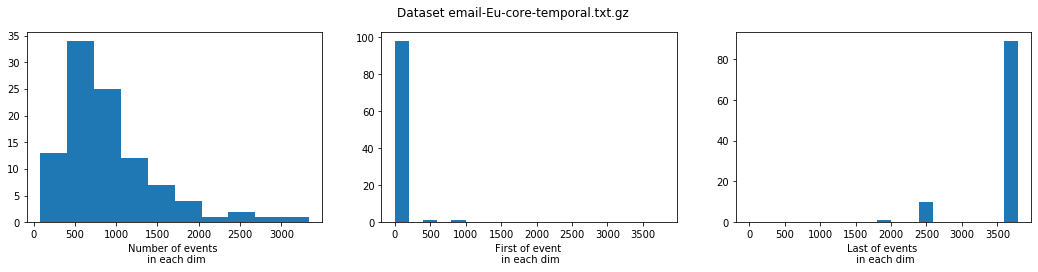

In [72]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

axs[0].hist(list(map(len, dataset.timestamps)))
axs[0].set_xlabel('Number of events \n in each dim')

end_time = dataset.end_time
axs[1].hist(list(map(min, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[1].set_xlabel('First of event \n in each dim')

axs[2].hist(list(map(max, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[2].set_xlabel('Last of events \n in each dim')

fig.suptitle(f"Dataset {os.path.split(INPUT_PATH)[1]}");

Print statistics of the dataset

In [73]:
print(f"Num. of dimensions: {len(dataset.timestamps):,d}")
print(f"    Num. of events: {sum(map(len, dataset.timestamps)):,d}")
print(f"               %NZ: {100 * dataset.graph.number_of_edges() / (dataset.graph.number_of_nodes() ** 2):.2f}%")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, dataset.timestamps)))
print(pd.Series(num_jumps_per_dim).describe())

Num. of dimensions: 100
    Num. of events: 92,924
               %NZ: 26.23%

Stats. of num. of events per dim:
count     100.000000
mean      929.240000
std       589.331261
min        82.000000
25%       544.000000
50%       770.000000
75%      1210.000000
max      3334.000000
dtype: float64


#### Visualize the scale of time using empirical inter-arrival time distributions

Compute this for both definitions $\{\beta_j\}$ and $\{\beta_{ij}\}$.

Busca estimators of **beta_j**:
count    100.000000
mean       1.047821
std        1.697593
min        0.027073
25%        0.290703
50%        0.556093
75%        0.916578
max       13.945126
dtype: float64

Busca estimators of **beta_{ji}**:
count    10000.000000
mean         1.218508
std          2.322191
min          0.000000
25%          0.344152
50%          1.004831
75%          1.474058
max        118.573898
dtype: float64



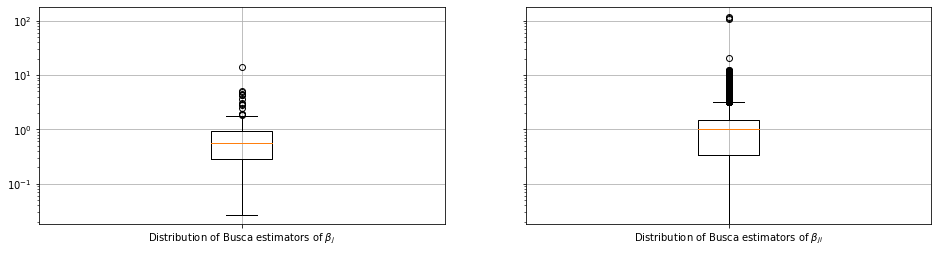

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

busca_betas = np.array([np.median(np.hstack((ev[0], np.diff(ev)))) for ev in dataset.timestamps])
plt.sca(axs[0])
plt.grid()
plt.boxplot(busca_betas, labels=[r'Distribution of Busca estimators of $\beta_j$']);
plt.yscale('log')
print('Busca estimators of **beta_j**:')
print(pd.Series(busca_betas.flatten()).describe())
print()

wold_model = tsvar.models.WoldModel()
wold_model.observe(dataset.timestamps)
busca_beta_ji = np.zeros((wold_model.dim, wold_model.dim))
for i in range(wold_model.dim):
    busca_beta_ji[:, i] = np.median(wold_model.delta_ikj[i][:, :], axis=0) / np.exp(1)
del wold_model
plt.sca(axs[1])
plt.grid()
plt.boxplot(busca_beta_ji.flatten(), labels=[r'Distribution of Busca estimators of $\beta_{ji}$']);
plt.yscale('log')
print('Busca estimators of **beta_{ji}**:')
print(pd.Series(busca_beta_ji.flatten()).describe())
print()

Build ground truth adjacency matrix

In [87]:
adjacency_true = nx.adjacency_matrix(dataset.graph, nodelist=range(dataset.dim)).toarray()
adjacency_true = adjacency_true / adjacency_true.max()

In [88]:
events = dataset.timestamps
end_time = dataset.end_time

---

## Run inference

---

### Run BBVI

In [ ]:
dim = len(events)
n_params = dim + dim**2 + dim**2
end_time = max(map(max, events))

# Set initial guess
coeffs_start = torch.tensor(np.hstack((
    # loc
    -2.0 * torch.ones(dim, dtype=torch.float),                  # baseline
    0.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # beta
    -2.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # adjacency
    # scale
    torch.log(0.2 * torch.ones(dim, dtype=torch.float)),
    torch.log(0.2 * torch.ones((dim, dim), dtype=torch.float).flatten()),
    torch.log(0.2 * torch.ones((dim, dim), dtype=torch.float).flatten()),
)))

# Define priors/posteriors
posterior = tsvar.posteriors.LogNormalPosterior
prior = tsvar.priors.GaussianLaplacianPrior
mask_gaus = torch.zeros(n_params, dtype=torch.bool)
mask_gaus[:dim + dim**2] = 1  # Gaussian prior for baseline and beta
C = 1e3

# Init the model object
model = tsvar.models.WoldModelBBVI(posterior=posterior, prior=prior, C=C,
                                   prior_kwargs={'mask_gaus': mask_gaus},
                                   n_samples=1, n_weights=1, weight_temp=1,
                                   verbose=False, device='cpu')
model.observe(events, end_time)

# Set link function for callback (vi coeffs -> posterior mode)
def link_func(coeffs):
    """variationa coeffs -> posterior mode of adjacency"""
    # Numpy to torch
    coeffs = torch.tensor(coeffs) if isinstance(coeffs, np.ndarray) else coeffs
    return model.posterior.mode(
        coeffs[:model.n_params], coeffs[model.n_params:]
    ).detach().numpy()[dim:dim+dim**2]

# Set the callback (callback parameters are posterior mode)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=posterior().mode(
        coeffs_start[:dim+2*dim**2], coeffs_start[dim+2*dim**2:]
    )[dim:dim+dim**2],
    print_every=1,
    coeffs_true=adjacency_true,
    acc_thresh=0.05,
    dim=dim,
    link_func=link_func,
    default_end='\n')

# Fit the model
conv = model.fit(x0=coeffs_start, optimizer=torch.optim.Adam, lr=1e-1,
                 lr_sched=0.9999, tol=1e-6, max_iter=20000,
                 mstep_interval=100, mstep_offset=500, mstep_momentum=0.5,
                 seed=None, callback=callback)

iter:     1 | dx: +1.0877e-01 | loss: 1.2720e+06 | dloss: -inf | acc: 0.26 | f1-score: 0.42 | relerr: 2.46e+03 | p@5: 0.20 | p@10: 0.20 | p@20: 0.25 | time/it: 3.57e-01     
iter:     2 | dx: +1.1968e-01 | loss: 1.1104e+06 | dloss: -1.62e+05 | acc: 0.26 | f1-score: 0.42 | relerr: 2.71e+03 | p@5: 0.20 | p@10: 0.30 | p@20: 0.30 | time/it: 3.92e-01     
iter:     3 | dx: +1.3185e-01 | loss: 9.7113e+05 | dloss: -1.39e+05 | acc: 0.26 | f1-score: 0.42 | relerr: 2.98e+03 | p@5: 0.40 | p@10: 0.30 | p@20: 0.40 | time/it: 3.91e-01     
iter:     4 | dx: +1.4592e-01 | loss: 8.5763e+05 | dloss: -1.14e+05 | acc: 0.26 | f1-score: 0.42 | relerr: 3.27e+03 | p@5: 0.40 | p@10: 0.40 | p@20: 0.35 | time/it: 3.79e-01     
iter:     5 | dx: +1.6032e-01 | loss: 7.5167e+05 | dloss: -1.06e+05 | acc: 0.26 | f1-score: 0.42 | relerr: 3.59e+03 | p@5: 0.60 | p@10: 0.40 | p@20: 0.40 | time/it: 3.87e-01     
iter:     6 | dx: +1.7620e-01 | loss: 6.6820e+05 | dloss: -8.35e+04 | acc: 0.26 | f1-score: 0.42 | relerr: 3.9

iter:    47 | dx: +7.6211e-01 | loss: 2.6409e+05 | dloss: +3.17e+04 | acc: 0.27 | f1-score: 0.41 | relerr: 1.58e+04 | p@5: 0.20 | p@10: 0.10 | p@20: 0.10 | time/it: 3.71e-01     
iter:    48 | dx: +7.9043e-01 | loss: 3.2309e+05 | dloss: +5.90e+04 | acc: 0.27 | f1-score: 0.41 | relerr: 1.58e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.10 | time/it: 7.20e-01     
iter:    49 | dx: +7.4376e-01 | loss: 3.0736e+05 | dloss: -1.57e+04 | acc: 0.27 | f1-score: 0.41 | relerr: 1.58e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.10 | time/it: 4.63e-01     
iter:    50 | dx: +8.7932e-01 | loss: 1.2746e+06 | dloss: +9.67e+05 | acc: 0.27 | f1-score: 0.41 | relerr: 1.57e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.15 | time/it: 4.16e-01     
iter:    51 | dx: +8.6444e-01 | loss: 2.4968e+05 | dloss: -1.02e+06 | acc: 0.27 | f1-score: 0.41 | relerr: 1.57e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.15 | time/it: 3.72e-01     
iter:    52 | dx: +8.8284e-01 | loss: 1.8667e+06 | dloss: +1.62e+06 | acc: 0.27 | f1-score: 0.41 | relerr

iter:    93 | dx: +1.5421e+00 | loss: 3.1816e+05 | dloss: +1.18e+05 | acc: 0.26 | f1-score: 0.41 | relerr: 1.98e+04 | p@5: 0.00 | p@10: 0.00 | p@20: 0.10 | time/it: 3.69e-01     
iter:    94 | dx: +1.4583e+00 | loss: 1.9723e+05 | dloss: -1.21e+05 | acc: 0.26 | f1-score: 0.41 | relerr: 2.00e+04 | p@5: 0.00 | p@10: 0.00 | p@20: 0.15 | time/it: 3.69e-01     
iter:    95 | dx: +1.7080e+00 | loss: 1.9843e+05 | dloss: +1.20e+03 | acc: 0.26 | f1-score: 0.41 | relerr: 2.02e+04 | p@5: 0.00 | p@10: 0.00 | p@20: 0.15 | time/it: 3.66e-01     
iter:    96 | dx: +1.9797e+00 | loss: 1.9872e+05 | dloss: +2.93e+02 | acc: 0.26 | f1-score: 0.41 | relerr: 2.04e+04 | p@5: 0.00 | p@10: 0.00 | p@20: 0.15 | time/it: 4.02e-01     
iter:    97 | dx: +1.9250e+00 | loss: 1.9929e+05 | dloss: +5.67e+02 | acc: 0.26 | f1-score: 0.41 | relerr: 2.06e+04 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 5.81e-01     
iter:    98 | dx: +1.7909e+00 | loss: 1.9652e+05 | dloss: -2.78e+03 | acc: 0.26 | f1-score: 0.41 | relerr

iter:   139 | dx: +1.8036e+00 | loss: 1.8947e+05 | dloss: -1.25e+03 | acc: 0.26 | f1-score: 0.41 | relerr: 2.83e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.20 | time/it: 3.95e-01     
iter:   140 | dx: +1.6106e+00 | loss: 1.9293e+05 | dloss: +3.46e+03 | acc: 0.26 | f1-score: 0.41 | relerr: 2.85e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.20 | time/it: 5.36e-01     
iter:   141 | dx: +1.7370e+00 | loss: 1.8962e+05 | dloss: -3.31e+03 | acc: 0.26 | f1-score: 0.41 | relerr: 2.87e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.15 | time/it: 4.75e-01     
iter:   142 | dx: +1.6057e+00 | loss: 1.9324e+05 | dloss: +3.62e+03 | acc: 0.26 | f1-score: 0.41 | relerr: 2.88e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.20 | time/it: 3.96e-01     
iter:   143 | dx: +1.9225e+00 | loss: 1.9358e+05 | dloss: +3.40e+02 | acc: 0.26 | f1-score: 0.41 | relerr: 2.90e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.15 | time/it: 4.37e-01     
iter:   144 | dx: +2.4905e+00 | loss: 1.8972e+05 | dloss: -3.86e+03 | acc: 0.26 | f1-score: 0.41 | relerr

iter:   185 | dx: +2.0166e+00 | loss: 1.8756e+05 | dloss: -1.25e+03 | acc: 0.26 | f1-score: 0.41 | relerr: 3.45e+04 | p@5: 0.20 | p@10: 0.30 | p@20: 0.25 | time/it: 3.80e-01     
iter:   186 | dx: +2.8503e+00 | loss: 1.8795e+05 | dloss: +3.87e+02 | acc: 0.26 | f1-score: 0.41 | relerr: 3.46e+04 | p@5: 0.20 | p@10: 0.40 | p@20: 0.25 | time/it: 3.75e-01     
iter:   187 | dx: +2.8000e+00 | loss: 1.8806e+05 | dloss: +1.07e+02 | acc: 0.26 | f1-score: 0.41 | relerr: 3.47e+04 | p@5: 0.20 | p@10: 0.40 | p@20: 0.25 | time/it: 3.74e-01     
iter:   188 | dx: +2.7484e+00 | loss: 1.8724e+05 | dloss: -8.15e+02 | acc: 0.26 | f1-score: 0.41 | relerr: 3.48e+04 | p@5: 0.20 | p@10: 0.40 | p@20: 0.20 | time/it: 4.24e-01     
iter:   189 | dx: +2.6843e+00 | loss: 1.8689e+05 | dloss: -3.50e+02 | acc: 0.26 | f1-score: 0.41 | relerr: 3.49e+04 | p@5: 0.20 | p@10: 0.40 | p@20: 0.20 | time/it: 4.77e-01     
iter:   190 | dx: +2.5940e+00 | loss: 1.8777e+05 | dloss: +8.78e+02 | acc: 0.26 | f1-score: 0.41 | relerr

iter:   231 | dx: +2.9576e+00 | loss: 1.8659e+05 | dloss: -6.29e+01 | acc: 0.26 | f1-score: 0.41 | relerr: 3.78e+04 | p@5: 0.20 | p@10: 0.10 | p@20: 0.20 | time/it: 4.44e-01     
iter:   232 | dx: +2.6375e+00 | loss: 1.8662e+05 | dloss: +3.55e+01 | acc: 0.26 | f1-score: 0.41 | relerr: 3.79e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.20 | time/it: 4.33e-01     
iter:   233 | dx: +2.3559e+00 | loss: 1.8660e+05 | dloss: -2.18e+01 | acc: 0.26 | f1-score: 0.41 | relerr: 3.79e+04 | p@5: 0.20 | p@10: 0.10 | p@20: 0.20 | time/it: 4.03e-01     
iter:   234 | dx: +3.0142e+00 | loss: 1.8648e+05 | dloss: -1.19e+02 | acc: 0.26 | f1-score: 0.41 | relerr: 3.80e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.25 | time/it: 4.16e-01     
iter:   235 | dx: +2.8742e+00 | loss: 1.8646e+05 | dloss: -1.83e+01 | acc: 0.26 | f1-score: 0.41 | relerr: 3.80e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 4.59e-01     
iter:   236 | dx: +2.7906e+00 | loss: 1.8677e+05 | dloss: +3.10e+02 | acc: 0.26 | f1-score: 0.41 | relerr

iter:   277 | dx: +3.8792e+00 | loss: 1.8618e+05 | dloss: +4.10e+02 | acc: 0.26 | f1-score: 0.41 | relerr: 3.91e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.35 | time/it: 4.42e-01     
iter:   278 | dx: +3.7598e+00 | loss: 1.8649e+05 | dloss: +3.13e+02 | acc: 0.26 | f1-score: 0.41 | relerr: 3.92e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.35 | time/it: 4.06e-01     
iter:   279 | dx: +3.5928e+00 | loss: 1.8589e+05 | dloss: -6.00e+02 | acc: 0.26 | f1-score: 0.41 | relerr: 3.92e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.35 | time/it: 4.04e-01     
iter:   280 | dx: +3.4416e+00 | loss: 1.8660e+05 | dloss: +7.13e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 3.92e+04 | p@5: 0.60 | p@10: 0.30 | p@20: 0.35 | time/it: 3.82e-01     
iter:   281 | dx: +3.1002e+00 | loss: 1.8596e+05 | dloss: -6.43e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 3.92e+04 | p@5: 0.60 | p@10: 0.30 | p@20: 0.35 | time/it: 4.20e-01     
iter:   282 | dx: +4.0774e+00 | loss: 1.8644e+05 | dloss: +4.78e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:   323 | dx: +6.3012e+00 | loss: 1.8557e+05 | dloss: -7.68e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 3.98e+04 | p@5: 0.40 | p@10: 0.50 | p@20: 0.35 | time/it: 4.10e-01     
iter:   324 | dx: +5.9764e+00 | loss: 1.8611e+05 | dloss: +5.35e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 3.98e+04 | p@5: 0.20 | p@10: 0.40 | p@20: 0.35 | time/it: 3.71e-01     
iter:   325 | dx: +5.3607e+00 | loss: 1.8555e+05 | dloss: -5.54e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 3.98e+04 | p@5: 0.20 | p@10: 0.40 | p@20: 0.35 | time/it: 4.30e-01     
iter:   326 | dx: +4.7060e+00 | loss: 1.8580e+05 | dloss: +2.52e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 3.98e+04 | p@5: 0.20 | p@10: 0.40 | p@20: 0.35 | time/it: 4.38e-01     
iter:   327 | dx: +4.1323e+00 | loss: 1.8553e+05 | dloss: -2.80e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 3.98e+04 | p@5: 0.20 | p@10: 0.40 | p@20: 0.40 | time/it: 4.02e-01     
iter:   328 | dx: +3.5687e+00 | loss: 1.8538e+05 | dloss: -1.45e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:   369 | dx: +3.6039e+00 | loss: 1.8532e+05 | dloss: +1.25e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.03e+04 | p@5: 0.00 | p@10: 0.00 | p@20: 0.05 | time/it: 6.29e-01     
iter:   370 | dx: +3.4226e+00 | loss: 1.9381e+05 | dloss: +8.49e+03 | acc: 0.27 | f1-score: 0.41 | relerr: 4.03e+04 | p@5: 0.00 | p@10: 0.10 | p@20: 0.05 | time/it: 5.40e-01     
iter:   371 | dx: +3.3339e+00 | loss: 1.8630e+05 | dloss: -7.51e+03 | acc: 0.27 | f1-score: 0.41 | relerr: 4.03e+04 | p@5: 0.00 | p@10: 0.00 | p@20: 0.05 | time/it: 4.19e-01     
iter:   372 | dx: +3.1880e+00 | loss: 1.8539e+05 | dloss: -9.07e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.03e+04 | p@5: 0.00 | p@10: 0.10 | p@20: 0.05 | time/it: 4.53e-01     
iter:   373 | dx: +4.4723e+00 | loss: 1.8558e+05 | dloss: +1.87e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.03e+04 | p@5: 0.00 | p@10: 0.00 | p@20: 0.05 | time/it: 5.52e-01     
iter:   374 | dx: +4.4899e+00 | loss: 1.8544e+05 | dloss: -1.37e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:   415 | dx: +4.5010e+00 | loss: 1.8557e+05 | dloss: +3.46e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.04e+04 | p@5: 0.20 | p@10: 0.30 | p@20: 0.25 | time/it: 4.32e-01     
iter:   416 | dx: +4.6132e+00 | loss: 1.8763e+05 | dloss: +2.06e+03 | acc: 0.27 | f1-score: 0.41 | relerr: 4.04e+04 | p@5: 0.20 | p@10: 0.30 | p@20: 0.25 | time/it: 3.98e-01     
iter:   417 | dx: +4.6739e+00 | loss: 1.8537e+05 | dloss: -2.27e+03 | acc: 0.27 | f1-score: 0.41 | relerr: 4.04e+04 | p@5: 0.20 | p@10: 0.30 | p@20: 0.25 | time/it: 4.07e-01     
iter:   418 | dx: +4.6331e+00 | loss: 1.8732e+05 | dloss: +1.95e+03 | acc: 0.27 | f1-score: 0.41 | relerr: 4.04e+04 | p@5: 0.20 | p@10: 0.30 | p@20: 0.30 | time/it: 3.91e-01     
iter:   419 | dx: +5.4276e+00 | loss: 1.8610e+05 | dloss: -1.22e+03 | acc: 0.27 | f1-score: 0.41 | relerr: 4.04e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 3.88e-01     
iter:   420 | dx: +5.6195e+00 | loss: 1.8526e+05 | dloss: -8.48e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:   461 | dx: +3.6998e+00 | loss: 1.8552e+05 | dloss: +4.62e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.06e+04 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 3.71e-01     
iter:   462 | dx: +3.4370e+00 | loss: 1.8488e+05 | dloss: -6.46e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.06e+04 | p@5: 0.00 | p@10: 0.00 | p@20: 0.20 | time/it: 4.07e-01     
iter:   463 | dx: +3.2135e+00 | loss: 1.8506e+05 | dloss: +1.87e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.06e+04 | p@5: 0.00 | p@10: 0.00 | p@20: 0.15 | time/it: 5.10e-01     
iter:   464 | dx: +5.6889e+00 | loss: 1.8545e+05 | dloss: +3.88e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.06e+04 | p@5: 0.00 | p@10: 0.00 | p@20: 0.15 | time/it: 4.47e-01     
iter:   465 | dx: +5.7596e+00 | loss: 1.8554e+05 | dloss: +9.46e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 4.06e+04 | p@5: 0.00 | p@10: 0.00 | p@20: 0.10 | time/it: 3.92e-01     
iter:   466 | dx: +5.7184e+00 | loss: 1.8538e+05 | dloss: -1.66e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:   507 | dx: +6.2538e+00 | loss: 1.8524e+05 | dloss: +3.17e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.07e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.10 | time/it: 5.48e-01     
iter:   508 | dx: +6.0133e+00 | loss: 1.8479e+05 | dloss: -4.47e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.07e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.10 | time/it: 3.88e-01     
iter:   509 | dx: +5.5941e+00 | loss: 1.8504e+05 | dloss: +2.54e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.07e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.10 | time/it: 5.32e-01     
iter:   510 | dx: +5.0367e+00 | loss: 1.8497e+05 | dloss: -7.53e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 4.07e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.10 | time/it: 5.50e-01     
iter:   511 | dx: +4.6249e+00 | loss: 1.8499e+05 | dloss: +2.33e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 4.07e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.10 | time/it: 3.89e-01     
iter:   512 | dx: +4.2666e+00 | loss: 1.8508e+05 | dloss: +9.40e+01 | acc: 0.27 | f1-score: 0.41 | relerr

iter:   553 | dx: +4.9215e+00 | loss: 1.8486e+05 | dloss: -1.36e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.09e+04 | p@5: 0.40 | p@10: 0.50 | p@20: 0.25 | time/it: 4.18e-01     
iter:   554 | dx: +4.6053e+00 | loss: 1.8499e+05 | dloss: +1.27e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.09e+04 | p@5: 0.40 | p@10: 0.50 | p@20: 0.25 | time/it: 4.26e-01     
iter:   555 | dx: +4.2241e+00 | loss: 1.8527e+05 | dloss: +2.75e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.09e+04 | p@5: 0.40 | p@10: 0.50 | p@20: 0.25 | time/it: 4.34e-01     
iter:   556 | dx: +3.8562e+00 | loss: 1.8516e+05 | dloss: -1.07e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.09e+04 | p@5: 0.60 | p@10: 0.40 | p@20: 0.25 | time/it: 3.90e-01     
iter:   557 | dx: +3.3596e+00 | loss: 1.8508e+05 | dloss: -7.44e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 4.09e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.25 | time/it: 3.97e-01     
iter:   558 | dx: +3.2088e+00 | loss: 1.8479e+05 | dloss: -2.96e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:   599 | dx: +3.3384e+00 | loss: 1.8511e+05 | dloss: +4.59e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.09e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.45 | time/it: 4.91e-01     
iter:   600 | dx: +3.5378e+00 | loss: 1.8551e+05 | dloss: +3.93e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.09e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.40 | time/it: 6.07e-01     
iter:   601 | dx: +4.1179e+00 | loss: 1.8447e+05 | dloss: -1.04e+03 | acc: 0.27 | f1-score: 0.41 | relerr: 4.09e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.40 | time/it: 4.48e-01     
iter:   602 | dx: +4.3382e+00 | loss: 1.8467e+05 | dloss: +2.05e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.09e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.35 | time/it: 3.81e-01     
iter:   603 | dx: +4.5178e+00 | loss: 1.8397e+05 | dloss: -6.98e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.09e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.30 | time/it: 3.77e-01     
iter:   604 | dx: +4.6063e+00 | loss: 1.8467e+05 | dloss: +7.00e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:   645 | dx: +5.6109e+00 | loss: 1.8360e+05 | dloss: -1.12e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.37e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.20 | time/it: 4.09e-01     
iter:   646 | dx: +5.8626e+00 | loss: 1.8373e+05 | dloss: +1.28e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.38e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.20 | time/it: 5.44e-01     
iter:   647 | dx: +5.9097e+00 | loss: 1.8380e+05 | dloss: +7.52e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 4.38e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.15 | time/it: 4.32e-01     
iter:   648 | dx: +5.8869e+00 | loss: 1.8382e+05 | dloss: +2.13e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 4.38e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.10 | time/it: 3.86e-01     
iter:   649 | dx: +5.8599e+00 | loss: 1.8357e+05 | dloss: -2.56e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.39e+04 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 3.71e-01     
iter:   650 | dx: +5.6570e+00 | loss: 1.8398e+05 | dloss: +4.15e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:   691 | dx: +5.3099e+00 | loss: 1.8350e+05 | dloss: -2.37e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.51e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.15 | time/it: 4.16e-01     
iter:   692 | dx: +6.8066e+00 | loss: 1.8373e+05 | dloss: +2.28e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.51e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.15 | time/it: 4.52e-01     
iter:   693 | dx: +7.8044e+00 | loss: 1.8409e+05 | dloss: +3.65e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.51e+04 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 4.62e-01     
iter:   694 | dx: +8.3672e+00 | loss: 1.8354e+05 | dloss: -5.56e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.51e+04 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 4.38e-01     
iter:   695 | dx: +8.8789e+00 | loss: 1.8360e+05 | dloss: +5.94e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 4.51e+04 | p@5: 0.20 | p@10: 0.20 | p@20: 0.15 | time/it: 4.25e-01     
iter:   696 | dx: +9.2844e+00 | loss: 1.8331e+05 | dloss: -2.89e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:   737 | dx: +8.2696e+00 | loss: 1.8241e+05 | dloss: -8.61e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 4.79e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.30 | time/it: 4.18e-01     
iter:   738 | dx: +8.1238e+00 | loss: 1.8287e+05 | dloss: +4.57e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.80e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.30 | time/it: 4.12e-01     
iter:   739 | dx: +9.8706e+00 | loss: 1.8309e+05 | dloss: +2.24e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.80e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.25 | time/it: 3.95e-01     
iter:   740 | dx: +9.6960e+00 | loss: 1.8261e+05 | dloss: -4.85e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.81e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.25 | time/it: 4.12e-01     
iter:   741 | dx: +9.5215e+00 | loss: 1.8248e+05 | dloss: -1.28e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 4.81e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 4.28e-01     
iter:   742 | dx: +9.1749e+00 | loss: 1.8282e+05 | dloss: +3.37e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:   783 | dx: +1.0202e+01 | loss: 1.8225e+05 | dloss: -8.45e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 5.02e+04 | p@5: 0.60 | p@10: 0.40 | p@20: 0.35 | time/it: 4.55e-01     
iter:   784 | dx: +1.0216e+01 | loss: 1.8246e+05 | dloss: +2.10e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 5.02e+04 | p@5: 0.60 | p@10: 0.40 | p@20: 0.40 | time/it: 5.93e-01     
iter:   785 | dx: +1.0287e+01 | loss: 1.8270e+05 | dloss: +2.34e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 5.02e+04 | p@5: 0.60 | p@10: 0.50 | p@20: 0.40 | time/it: 5.05e-01     
iter:   786 | dx: +9.8489e+00 | loss: 1.8272e+05 | dloss: +2.88e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 5.03e+04 | p@5: 0.40 | p@10: 0.50 | p@20: 0.40 | time/it: 3.85e-01     
iter:   787 | dx: +9.1353e+00 | loss: 1.8256e+05 | dloss: -1.65e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 5.03e+04 | p@5: 0.40 | p@10: 0.50 | p@20: 0.40 | time/it: 4.77e-01     
iter:   788 | dx: +8.7883e+00 | loss: 1.8259e+05 | dloss: +2.94e+01 | acc: 0.27 | f1-score: 0.41 | relerr

iter:   829 | dx: +9.0467e+00 | loss: 1.8120e+05 | dloss: +4.15e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 5.34e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.25 | time/it: 3.94e-01     
iter:   830 | dx: +8.5922e+00 | loss: 1.8141e+05 | dloss: +2.09e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 5.35e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.25 | time/it: 4.19e-01     
iter:   831 | dx: +8.1510e+00 | loss: 1.8121e+05 | dloss: -2.09e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 5.36e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.20 | time/it: 3.99e-01     
iter:   832 | dx: +7.8509e+00 | loss: 1.8122e+05 | dloss: +1.42e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 5.37e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 4.20e-01     
iter:   833 | dx: +8.1458e+00 | loss: 1.8183e+05 | dloss: +6.07e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 5.37e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 4.18e-01     
iter:   834 | dx: +8.3711e+00 | loss: 1.8144e+05 | dloss: -3.89e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:   875 | dx: +1.4411e+01 | loss: 1.8204e+05 | dloss: +2.18e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 5.58e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.35 | time/it: 4.32e-01     
iter:   876 | dx: +1.4846e+01 | loss: 1.8131e+05 | dloss: -7.29e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 5.58e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.35 | time/it: 4.10e-01     
iter:   877 | dx: +1.4980e+01 | loss: 1.8167e+05 | dloss: +3.61e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 5.59e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.35 | time/it: 4.02e-01     
iter:   878 | dx: +1.4624e+01 | loss: 1.8130e+05 | dloss: -3.73e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 5.59e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.30 | time/it: 3.98e-01     
iter:   879 | dx: +1.3607e+01 | loss: 1.8128e+05 | dloss: -2.03e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 5.59e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.35 | time/it: 3.93e-01     
iter:   880 | dx: +1.3120e+01 | loss: 1.8152e+05 | dloss: +2.45e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:   921 | dx: +5.4219e+01 | loss: 1.7994e+05 | dloss: -2.77e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 5.94e+04 | p@5: 0.40 | p@10: 0.50 | p@20: 0.35 | time/it: 4.61e-01     
iter:   922 | dx: +4.6648e+01 | loss: 1.8021e+05 | dloss: +2.61e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 5.95e+04 | p@5: 0.40 | p@10: 0.50 | p@20: 0.35 | time/it: 4.55e-01     
iter:   923 | dx: +4.0412e+01 | loss: 1.8046e+05 | dloss: +2.53e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 5.96e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.35 | time/it: 3.69e-01     
iter:   924 | dx: +2.7931e+01 | loss: 1.8072e+05 | dloss: +2.62e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 5.97e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.35 | time/it: 4.59e-01     
iter:   925 | dx: +1.5562e+01 | loss: 1.7999e+05 | dloss: -7.29e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 5.98e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.35 | time/it: 4.23e-01     
iter:   926 | dx: +1.3835e+01 | loss: 1.7988e+05 | dloss: -1.13e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:   967 | dx: +2.6089e+01 | loss: 1.8015e+05 | dloss: +4.00e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 6.24e+04 | p@5: 0.60 | p@10: 0.30 | p@20: 0.30 | time/it: 6.77e-01     
iter:   968 | dx: +2.5185e+01 | loss: 1.8008e+05 | dloss: -6.82e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 6.24e+04 | p@5: 0.60 | p@10: 0.30 | p@20: 0.25 | time/it: 5.72e-01     
iter:   969 | dx: +2.3162e+01 | loss: 1.8069e+05 | dloss: +6.04e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 6.25e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.25 | time/it: 6.02e-01     
iter:   970 | dx: +2.1666e+01 | loss: 1.8041e+05 | dloss: -2.76e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 6.25e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.25 | time/it: 5.17e-01     
iter:   971 | dx: +2.0350e+01 | loss: 1.7977e+05 | dloss: -6.38e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 6.26e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.25 | time/it: 4.37e-01     
iter:   972 | dx: +1.9107e+01 | loss: 1.7980e+05 | dloss: +2.89e+01 | acc: 0.27 | f1-score: 0.41 | relerr

iter:  1013 | dx: +1.7682e+01 | loss: 1.7912e+05 | dloss: -4.12e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 6.55e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.25 | time/it: 3.54e-01     
iter:  1014 | dx: +1.7102e+01 | loss: 1.8101e+05 | dloss: +1.89e+03 | acc: 0.27 | f1-score: 0.41 | relerr: 6.56e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.20 | time/it: 3.47e-01     
iter:  1015 | dx: +1.6768e+01 | loss: 1.7927e+05 | dloss: -1.73e+03 | acc: 0.27 | f1-score: 0.41 | relerr: 6.58e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.20 | time/it: 3.53e-01     
iter:  1016 | dx: +1.5205e+01 | loss: 1.8946e+05 | dloss: +1.02e+04 | acc: 0.27 | f1-score: 0.41 | relerr: 6.59e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.20 | time/it: 3.49e-01     
iter:  1017 | dx: +1.4300e+01 | loss: 1.7904e+05 | dloss: -1.04e+04 | acc: 0.27 | f1-score: 0.41 | relerr: 6.61e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.20 | time/it: 3.49e-01     
iter:  1018 | dx: +1.2233e+01 | loss: 1.7895e+05 | dloss: -8.46e+01 | acc: 0.27 | f1-score: 0.41 | relerr

iter:  1059 | dx: +1.3330e+01 | loss: 1.7928e+05 | dloss: +1.35e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 6.99e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.25 | time/it: 4.49e-01     
iter:  1060 | dx: +1.3019e+01 | loss: 1.7914e+05 | dloss: -1.46e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 7.00e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.25 | time/it: 4.39e-01     
iter:  1061 | dx: +3.1245e+01 | loss: 1.7921e+05 | dloss: +6.95e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 7.01e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.25 | time/it: 4.52e-01     
iter:  1062 | dx: +2.8664e+01 | loss: 1.7894e+05 | dloss: -2.65e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 7.01e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.25 | time/it: 3.80e-01     
iter:  1063 | dx: +2.5958e+01 | loss: 1.9190e+05 | dloss: +1.30e+04 | acc: 0.27 | f1-score: 0.41 | relerr: 7.02e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.25 | time/it: 3.90e-01     
iter:  1064 | dx: +2.3691e+01 | loss: 1.7931e+05 | dloss: -1.26e+04 | acc: 0.27 | f1-score: 0.41 | relerr

iter:  1105 | dx: +1.8763e+01 | loss: 1.7857e+05 | dloss: +7.17e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 7.27e+04 | p@5: 0.40 | p@10: 0.30 | p@20: 0.25 | time/it: 3.85e-01     
iter:  1106 | dx: +1.7845e+01 | loss: 1.7815e+05 | dloss: -4.21e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 7.28e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.25 | time/it: 3.73e-01     
iter:  1107 | dx: +1.8714e+01 | loss: 1.7792e+05 | dloss: -2.29e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 7.30e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.25 | time/it: 5.52e-01     
iter:  1108 | dx: +1.8199e+01 | loss: 1.7833e+05 | dloss: +4.13e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 7.31e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.25 | time/it: 4.33e-01     
iter:  1109 | dx: +2.0799e+01 | loss: 1.7822e+05 | dloss: -1.10e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 7.33e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.25 | time/it: 4.27e-01     
iter:  1110 | dx: +2.4359e+01 | loss: 1.7810e+05 | dloss: -1.21e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:  1151 | dx: +4.6778e+01 | loss: 1.7769e+05 | dloss: -1.89e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 7.83e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.35 | time/it: 3.53e-01     
iter:  1152 | dx: +4.6166e+01 | loss: 1.7839e+05 | dloss: +7.05e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 7.84e+04 | p@5: 0.20 | p@10: 0.50 | p@20: 0.30 | time/it: 3.77e-01     
iter:  1153 | dx: +4.3076e+01 | loss: 1.7842e+05 | dloss: +2.81e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 7.85e+04 | p@5: 0.20 | p@10: 0.50 | p@20: 0.30 | time/it: 4.12e-01     
iter:  1154 | dx: +4.0246e+01 | loss: 1.7797e+05 | dloss: -4.54e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 7.85e+04 | p@5: 0.20 | p@10: 0.40 | p@20: 0.30 | time/it: 4.03e-01     
iter:  1155 | dx: +3.7830e+01 | loss: 1.7758e+05 | dloss: -3.83e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 7.87e+04 | p@5: 0.20 | p@10: 0.40 | p@20: 0.30 | time/it: 3.87e-01     
iter:  1156 | dx: +3.3901e+01 | loss: 1.7747e+05 | dloss: -1.15e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:  1197 | dx: +2.6223e+01 | loss: 1.7774e+05 | dloss: -3.10e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 8.20e+04 | p@5: 0.40 | p@10: 0.40 | p@20: 0.25 | time/it: 5.44e-01     
iter:  1198 | dx: +2.6395e+01 | loss: 1.7764e+05 | dloss: -9.66e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 8.20e+04 | p@5: 0.20 | p@10: 0.40 | p@20: 0.25 | time/it: 4.50e-01     
iter:  1199 | dx: +3.4903e+01 | loss: 1.7755e+05 | dloss: -9.13e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 8.21e+04 | p@5: 0.20 | p@10: 0.40 | p@20: 0.25 | time/it: 7.94e-01     
iter:  1200 | dx: +3.2983e+01 | loss: 1.7732e+05 | dloss: -2.24e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 8.21e+04 | p@5: 0.20 | p@10: 0.40 | p@20: 0.25 | time/it: 7.63e-01     
iter:  1201 | dx: +3.1826e+01 | loss: 1.7673e+05 | dloss: -5.97e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 8.22e+04 | p@5: 0.20 | p@10: 0.40 | p@20: 0.25 | time/it: 8.46e-01     
iter:  1202 | dx: +2.8515e+01 | loss: 1.7700e+05 | dloss: +2.69e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:  1243 | dx: +3.9305e+01 | loss: 1.7648e+05 | dloss: +6.55e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 8.87e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.30 | time/it: 5.97e-01     
iter:  1244 | dx: +3.8556e+01 | loss: 1.7694e+05 | dloss: +4.61e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 8.88e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.30 | time/it: 5.29e-01     
iter:  1245 | dx: +3.0761e+01 | loss: 1.7618e+05 | dloss: -7.61e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 8.89e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.30 | time/it: 5.54e-01     
iter:  1246 | dx: +3.4037e+01 | loss: 1.7669e+05 | dloss: +5.07e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 8.90e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.35 | time/it: 6.80e-01     
iter:  1247 | dx: +2.0724e+01 | loss: 1.7622e+05 | dloss: -4.72e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 8.90e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.30 | time/it: 4.47e-01     
iter:  1248 | dx: +2.3080e+01 | loss: 1.7648e+05 | dloss: +2.60e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:  1289 | dx: +5.2193e+01 | loss: 1.7635e+05 | dloss: +1.99e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 9.17e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.30 | time/it: 4.03e-01     
iter:  1290 | dx: +5.1191e+01 | loss: 1.7630e+05 | dloss: -5.71e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 9.18e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.30 | time/it: 3.85e-01     
iter:  1291 | dx: +4.0301e+01 | loss: 1.7611e+05 | dloss: -1.90e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 9.19e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.30 | time/it: 3.75e-01     
iter:  1292 | dx: +3.2038e+01 | loss: 1.7616e+05 | dloss: +4.86e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 9.21e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.30 | time/it: 3.82e-01     
iter:  1293 | dx: +4.7429e+01 | loss: 1.7666e+05 | dloss: +5.06e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 9.21e+04 | p@5: 0.40 | p@10: 0.20 | p@20: 0.30 | time/it: 1.66e+00     
iter:  1294 | dx: +5.2843e+01 | loss: 1.7612e+05 | dloss: -5.39e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:  1335 | dx: +2.4593e+01 | loss: 1.7566e+05 | dloss: +6.72e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 9.87e+04 | p@5: 0.20 | p@10: 0.30 | p@20: 0.30 | time/it: 5.28e-01     
iter:  1336 | dx: +2.0345e+01 | loss: 1.7504e+05 | dloss: -6.25e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 9.88e+04 | p@5: 0.20 | p@10: 0.30 | p@20: 0.30 | time/it: 4.79e-01     
iter:  1337 | dx: +1.7799e+01 | loss: 1.7515e+05 | dloss: +1.07e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 9.89e+04 | p@5: 0.20 | p@10: 0.30 | p@20: 0.35 | time/it: 4.19e-01     
iter:  1338 | dx: +1.6391e+01 | loss: 1.7529e+05 | dloss: +1.41e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 9.90e+04 | p@5: 0.20 | p@10: 0.30 | p@20: 0.35 | time/it: 3.84e-01     
iter:  1339 | dx: +2.0848e+01 | loss: 1.7576e+05 | dloss: +4.71e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 9.91e+04 | p@5: 0.20 | p@10: 0.30 | p@20: 0.35 | time/it: 3.46e-01     
iter:  1340 | dx: +4.5839e+01 | loss: 1.7523e+05 | dloss: -5.22e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:  1381 | dx: +4.3679e+01 | loss: 1.7522e+05 | dloss: +9.49e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 1.03e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.15 | time/it: 3.51e-01     
iter:  1382 | dx: +3.7642e+01 | loss: 1.7968e+05 | dloss: +4.46e+03 | acc: 0.27 | f1-score: 0.41 | relerr: 1.03e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.15 | time/it: 5.24e-01     
iter:  1383 | dx: +3.8983e+01 | loss: 1.9299e+05 | dloss: +1.33e+04 | acc: 0.27 | f1-score: 0.41 | relerr: 1.03e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.15 | time/it: 3.91e-01     
iter:  1384 | dx: +4.3985e+01 | loss: 1.7491e+05 | dloss: -1.81e+04 | acc: 0.27 | f1-score: 0.41 | relerr: 1.03e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.15 | time/it: 3.89e-01     
iter:  1385 | dx: +3.7579e+01 | loss: 1.7494e+05 | dloss: +3.09e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 1.03e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 4.05e-01     
iter:  1386 | dx: +3.1916e+01 | loss: 1.7502e+05 | dloss: +8.36e+01 | acc: 0.27 | f1-score: 0.41 | relerr

iter:  1427 | dx: +2.7075e+01 | loss: 1.7405e+05 | dloss: -3.06e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 1.11e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.15 | time/it: 3.78e-01     
iter:  1428 | dx: +2.4739e+01 | loss: 1.7396e+05 | dloss: -8.76e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 1.11e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.15 | time/it: 3.98e-01     
iter:  1429 | dx: +1.9713e+01 | loss: 1.7390e+05 | dloss: -6.60e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 1.11e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.15 | time/it: 3.81e-01     
iter:  1430 | dx: +2.0244e+01 | loss: 1.7378e+05 | dloss: -1.20e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 1.12e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.15 | time/it: 3.63e-01     
iter:  1431 | dx: +2.6664e+01 | loss: 1.7374e+05 | dloss: -3.72e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 1.12e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.15 | time/it: 3.49e-01     
iter:  1432 | dx: +2.7217e+01 | loss: 1.7379e+05 | dloss: +5.09e+01 | acc: 0.27 | f1-score: 0.41 | relerr

iter:  1473 | dx: +4.3805e+01 | loss: 1.7399e+05 | dloss: -3.97e+03 | acc: 0.27 | f1-score: 0.41 | relerr: 1.14e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.25 | time/it: 4.59e-01     
iter:  1474 | dx: +4.2937e+01 | loss: 1.7381e+05 | dloss: -1.70e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 1.15e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.25 | time/it: 4.07e-01     
iter:  1475 | dx: +4.2889e+01 | loss: 1.7387e+05 | dloss: +5.73e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 1.15e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 3.96e-01     
iter:  1476 | dx: +4.1690e+01 | loss: 1.7772e+05 | dloss: +3.85e+03 | acc: 0.27 | f1-score: 0.41 | relerr: 1.15e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 4.14e-01     
iter:  1477 | dx: +4.3295e+01 | loss: 1.7375e+05 | dloss: -3.97e+03 | acc: 0.27 | f1-score: 0.41 | relerr: 1.15e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 3.92e-01     
iter:  1478 | dx: +1.3784e+02 | loss: 1.7386e+05 | dloss: +1.17e+02 | acc: 0.27 | f1-score: 0.41 | relerr

iter:  1519 | dx: +3.5981e+01 | loss: 1.7308e+05 | dloss: -6.59e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 1.21e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 3.66e-01     
iter:  1520 | dx: +3.1134e+01 | loss: 1.7313e+05 | dloss: +5.72e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 1.21e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 3.94e-01     
iter:  1521 | dx: +2.6284e+01 | loss: 1.7313e+05 | dloss: -8.04e-01 | acc: 0.27 | f1-score: 0.41 | relerr: 1.21e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 3.83e-01     
iter:  1522 | dx: +2.1632e+01 | loss: 1.7304e+05 | dloss: -9.23e+01 | acc: 0.27 | f1-score: 0.41 | relerr: 1.21e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.25 | time/it: 4.01e-01     
iter:  1523 | dx: +4.2527e+01 | loss: 1.7276e+05 | dloss: -2.82e+02 | acc: 0.27 | f1-score: 0.41 | relerr: 1.22e+05 | p@5: 0.40 | p@10: 0.30 | p@20: 0.25 | time/it: 3.92e-01     
iter:  1524 | dx: +3.9523e+01 | loss: 1.7315e+05 | dloss: +3.93e+02 | acc: 0.27 | f1-score: 0.41 | relerr

In [94]:
coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:]).detach().numpy()
beta_hat = coeffs_hat[dim:dim+dim**2]
adj_hat = coeffs_hat[dim+dim**2:]

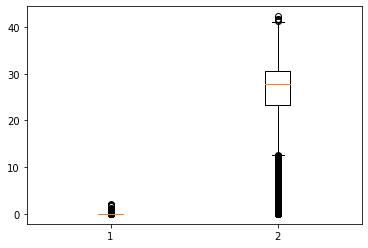

In [98]:
plt.boxplot([adj_hat.flatten(), beta_hat.flatten()]);

In [ ]:
coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:]).detach().numpy()
beta_hat = coeffs_hat[dim:dim+dim**2]
adj_hat = coeffs_hat[dim+dim**2:]

adj_hat = adj_hat / beta_hat

experiments_utils.print_report(adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.05)

---

### Run VI-fb

In [ ]:
dim = len(events)

# Set priors
as_pr = 10.0 * np.ones((dim + 1, dim))
ar_pr = 10.0 * np.ones((dim + 1, dim))

zc_pr = [1.0 * np.ones((len(ev), dim+1)) for ev in events]

beta = 1.0 * np.ones((dim, dim))
#beta = busca_beta_ji

In [ ]:
# Set model
vifb_model = tsvar.models.WoldModelVariationalFixedBeta(verbose=True)
vifb_model.observe(events, beta=busca_beta_ji)

In [ ]:
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr / ar_pr).flatten(), print_every=10,
    coeffs_true=adjacency_true.flatten(),
    acc_thresh=0.05, dim=dim, 
    widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
    default_end='\n')

# Fit model
conv = vifb_model.fit(as_pr=as_pr, ar_pr=ar_pr, zc_pr=zc_pr, max_iter=5000,
                 tol=1e-5, callback=callback)
print('Converged?', conv)

In [ ]:
adj_hat_mode = (vifb_model._as_po[1:, :] - 1) / vifb_model._ar_po[1:, :] 
adj_hat_mode[adj_hat_mode < 0] = 0

adj_hat_mean = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]

adj_hat_std = np.sqrt(vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :] ** 2)

#adj_hat = adj_hat_mean / adj_hat_std
adj_hat = adj_hat_mean
#adj_hat = adj_hat_mode

experiments_utils.print_report(adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.05)

In [ ]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [
        adj_hat[adjacency_true == 0.0], 
        adj_hat[adjacency_true > 0.0]
    ],
    labels=[
        'True Non-edges',
        'True Edges'
    ])
plt.ylabel(r'Learned value of paramaters')
plt.title('Distribution of learned adjacency weights');

---

### Run VI

In [15]:
dim = len(events)

# Set priors
# prior: Alpha
as_pr = 0.1 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 110.0 * np.ones((dim, dim))
br_pr = 100.0 * np.ones((dim, dim))

# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('mean')
print(as_pr[0,0] / ar_pr[0,0])
print('variance')
print(as_pr[0,0] / ar_pr[0,0] ** 2)

print('BETA:')
print('-----')
print('mean')
print(br_pr[0,0] / (bs_pr[0,0] - 1))
print('variance')
print(br_pr[0,0]**2 / ((bs_pr[0,0] - 1)**2 * (bs_pr[0,0] - 2)))

ALPHA:
------
mean
0.1
variance
0.1
BETA:
-----
mean
0.9174311926605505
variance
0.0077933332709866675


In [16]:
# Set model & observations
vi_model = tsvar.models.WoldModelVariational(verbose=True)
vi_model.observe(events)

In [17]:
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr[1:,:] / ar_pr[1:,:]).flatten(), print_every=1,
    coeffs_true=adjacency_true.flatten(),
    acc_thresh=0.05, dim=dim, 
    widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
    default_end='\n')

# Fit model
vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
          max_iter=2500, tol=1e-5, callback=callback)

iter:     1 | dx: +9.9672e-02 | f1-score: 0.00 | relerr: 1.76e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 6.40e+01     
iter:     2 | dx: +5.9528e-02 | f1-score: 0.00 | relerr: 1.87e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 3.67e+00     
iter:     3 | dx: +8.5465e-02 | f1-score: 0.01 | relerr: 1.93e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 3.73e+00     
iter:     4 | dx: +1.1786e-01 | f1-score: 0.02 | relerr: 2.01e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.10 | time/it: 3.45e+00     
iter:     5 | dx: +1.4399e-01 | f1-score: 0.03 | relerr: 2.07e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.10 | time/it: 3.45e+00     
iter:     6 | dx: +1.5653e-01 | f1-score: 0.03 | relerr: 2.12e+01 | p@5: 0.00 | p@10: 0.20 | p@20: 0.20 | time/it: 3.88e+00     
iter:     7 | dx: +1.5080e-01 | f1-score: 0.04 | relerr: 2.16e+01 | p@5: 0.00 | p@10: 0.20 | p@20: 0.25 | time/it: 4.43e+00     
iter:     8 | dx: +1.2873e-01 | f1-score: 0.05 | relerr: 2.19e+01 | p@5: 0.00 | p@10: 0.30 | p@20

iter:    65 | dx: +4.8652e-03 | f1-score: 0.09 | relerr: 2.02e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 3.88e+00     
iter:    66 | dx: +4.7956e-03 | f1-score: 0.09 | relerr: 2.02e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 3.78e+00     
iter:    67 | dx: +4.7100e-03 | f1-score: 0.09 | relerr: 2.02e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 4.66e+00     
iter:    68 | dx: +4.6144e-03 | f1-score: 0.09 | relerr: 2.01e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 5.13e+00     
iter:    69 | dx: +4.5371e-03 | f1-score: 0.09 | relerr: 2.01e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 7.21e+00     
iter:    70 | dx: +4.4426e-03 | f1-score: 0.09 | relerr: 2.01e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 4.67e+00     
iter:    71 | dx: +4.3376e-03 | f1-score: 0.09 | relerr: 2.01e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 3.97e+00     
iter:    72 | dx: +4.2469e-03 | f1-score: 0.09 | relerr: 2.01e+01 | p@5: 0.20 | p@10: 0.20 | p@20

iter:   129 | dx: +1.0522e-03 | f1-score: 0.09 | relerr: 1.99e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 1.39e+00     
iter:   130 | dx: +1.0426e-03 | f1-score: 0.09 | relerr: 1.99e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 1.40e+00     
iter:   131 | dx: +1.0506e-03 | f1-score: 0.09 | relerr: 1.99e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 1.41e+00     
iter:   132 | dx: +1.0466e-03 | f1-score: 0.09 | relerr: 1.99e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 1.41e+00     
iter:   133 | dx: +1.0422e-03 | f1-score: 0.09 | relerr: 1.99e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 1.39e+00     
iter:   134 | dx: +1.0442e-03 | f1-score: 0.09 | relerr: 1.99e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 1.39e+00     
iter:   135 | dx: +1.0368e-03 | f1-score: 0.09 | relerr: 1.99e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.30 | time/it: 1.45e+00     
iter:   136 | dx: +1.0423e-03 | f1-score: 0.09 | relerr: 1.99e+01 | p@5: 0.20 | p@10: 0.20 | p@20

iter:   193 | dx: +5.7608e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.42e+00     
iter:   194 | dx: +5.8892e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.47e+00     
iter:   195 | dx: +5.9642e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.48e+00     
iter:   196 | dx: +5.9175e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.50e+00     
iter:   197 | dx: +5.5739e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.51e+00     
iter:   198 | dx: +5.5147e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.46e+00     
iter:   199 | dx: +5.6600e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.49e+00     
iter:   200 | dx: +5.8117e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20

iter:   257 | dx: +6.3173e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.42e+00     
iter:   258 | dx: +6.4596e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.43e+00     
iter:   259 | dx: +6.5773e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.43e+00     
iter:   260 | dx: +6.6422e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.45e+00     
iter:   261 | dx: +6.5924e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.52e+00     
iter:   262 | dx: +6.2739e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.65e+00     
iter:   263 | dx: +5.2706e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.54e+00     
iter:   264 | dx: +4.0443e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20

iter:   321 | dx: +3.0280e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.48e+00     
iter:   322 | dx: +3.0959e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.57e+00     
iter:   323 | dx: +3.1390e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.50e+00     
iter:   324 | dx: +3.1268e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.73e+00     
iter:   325 | dx: +2.9824e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.50e+00     
iter:   326 | dx: +2.8588e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.54e+00     
iter:   327 | dx: +2.9422e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.45e+00     
iter:   328 | dx: +3.0288e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20

iter:   385 | dx: +1.4921e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.45e+00     
iter:   386 | dx: +1.5115e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.46e+00     
iter:   387 | dx: +1.5416e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.45e+00     
iter:   388 | dx: +1.5756e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.45e+00     
iter:   389 | dx: +1.6106e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.46e+00     
iter:   390 | dx: +1.6470e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.46e+00     
iter:   391 | dx: +1.6849e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.35 | time/it: 1.39e+00     
iter:   392 | dx: +1.7248e-04 | f1-score: 0.09 | relerr: 1.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20

True

In [18]:
print('as nan:', np.isnan(vi_model._as_po).any())
print('ar nan:', np.isnan(vi_model._ar_po).any())
print('bs nan:', np.isnan(vi_model._bs_po).any())
print('br nan:', np.isnan(vi_model._br_po).any())
print('bs < 0:', np.any(vi_model._bs_po < 0))
print('br < 0:', np.any(vi_model._br_po < 0))
print('x0 < 0:', np.any(vi_model._b_x0 < 0))
print('xn < 0:', np.any(vi_model._b_xn < 0))
print('x0 inf:', np.any(vi_model._b_x0 > 1e10))
print('xn inf:', np.any(vi_model._b_xn > 1e10))

as nan: False
ar nan: False
bs nan: False
br nan: False
bs < 0: False
br < 0: False
x0 < 0: False
xn < 0: False
x0 inf: False
xn inf: False


In [35]:
adj_hat = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
beta_hat = vi_model._br_po[:, :] / (vi_model._bs_po[:, :] + 1) + 1

#adj_hat = adj_hat
adj_hat = adj_hat / beta_hat

experiments_utils.print_report(adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.001)

Accuracy: 0.70

Edge counts
------------
Pred: 804.00
True: 2623.00

Error counts
------------
 True Positive: 210.00
False Positive: 594.00
 True Negative: 6783.00
False Negative: 2413.00

Error rates
-----------
 True Positive Rate: 0.08
False Positive Rate: 0.08
 True Negative Rate: 0.92
False Negative Rate: 0.92

F-Score
-------
 F1-Score: 0.12
Precision: 0.26
   Recall: 0.08

Precision@k
-----------
 Prec@5: 0.20
Prec@10: 0.30
Prec@20: 0.30

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.06868686868686873
10 0.13434343434343418
20 0.21414141414141405



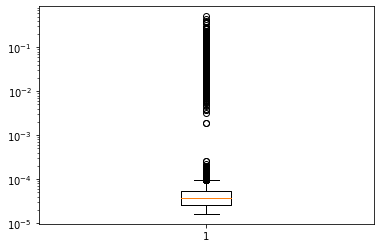

In [38]:
plt.boxplot(adj_hat.flatten());
plt.yscale('log');

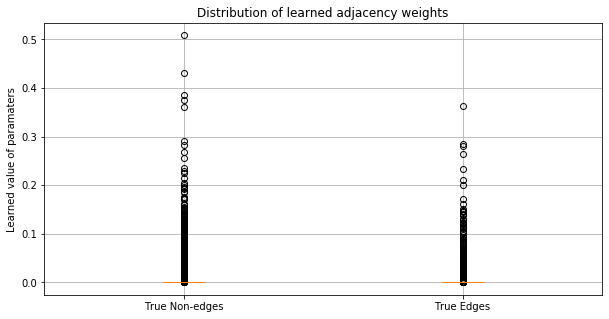

In [30]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [adj_hat[adjacency_true == 0.0], adj_hat[adjacency_true > 0.0]],
    labels=['True Non-edges', 'True Edges'])
plt.ylabel(r'Learned value of paramaters')
plt.title('Distribution of learned adjacency weights');

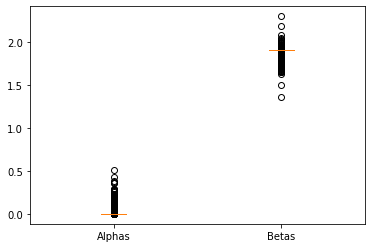

In [31]:
plt.boxplot([adj_hat.flatten(), beta_hat.flatten()], labels=['Alphas', 'Betas']);

---

### Run GB

In [32]:
import gb
import time

dim = len(events)

# Define model
granger_model = gb.GrangerBusca(
    alpha_prior=1.0/len(events),
    num_iter=3000,
    metropolis=True,
    beta_strategy='busca',
    num_jobs=4,
)
granger_model.fit(events)

In [34]:
# Extract infered adjacency
adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
beta_hat = np.ones((dim, dim)) * (granger_model.beta_ + 1)
coeffs_hat = np.hstack((granger_model.mu_, beta_hat.flatten(),
                        adj_hat.flatten()))

#adj_hat = adj_hat / beta_hat  # Does not matter


THRESH = 0.00  # GB is already sparse

experiments_utils.print_report(adj_hat=adj_hat, adj_true=adjacency_true, thresh=0)

Accuracy: 0.26

Edge counts
------------
Pred: 460.00
True: 2623.00

Error counts
------------
 True Positive: 151.00
False Positive: 309.00
 True Negative: 7068.00
False Negative: 2472.00

Error rates
-----------
 True Positive Rate: 0.06
False Positive Rate: 0.04
 True Negative Rate: 0.96
False Negative Rate: 0.94

F-Score
-------
 F1-Score: 0.10
Precision: 0.33
   Recall: 0.06

Precision@k
-----------
 Prec@5: 0.00
Prec@10: 0.00
Prec@20: 0.00

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.2747474747474746
10 0.24646464646464655
20 0.18030303030303027



In [161]:
tsvar.utils.metrics.relerr(adj_hat.flatten(), adjacency_true.flatten(), null_norm='none')

0.7420330871354197

In [180]:
scipy.stats.kendalltau(adj_hat.flatten(), adjacency_true.flatten())

KendalltauResult(correlation=-0.03233722944985986, pvalue=0.0005001328376041202)

In [166]:
tsvar.utils.metrics.mean_kendall_rank_corr(adj_hat.flatten(), adjacency_true.flatten())

-0.039862506938532154

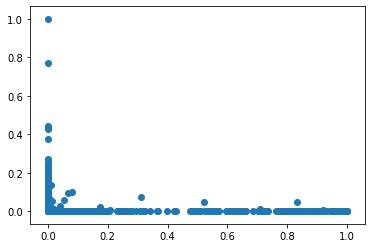

In [167]:
plt.scatter(adj_hat.flatten(), adjacency_true.flatten())

In [181]:
mean_rank_corr, rank_corr_per_dim = tsvar.utils.metrics.mean_kendall_rank_corr(
    adj_hat.flatten(), adjacency_true.flatten(), return_vec=True)

In [182]:
mean_rank_corr

-0.039862506938532154

(array([ 6., 17., 24., 15., 12.,  7.,  8.,  4.,  3.,  4.]),
 array([-0.16471, -0.13208, -0.09946, -0.06683, -0.0342 , -0.00158,  0.03105,  0.06367,  0.0963 ,  0.12893,  0.16155]),
 <a list of 10 Patch objects>)

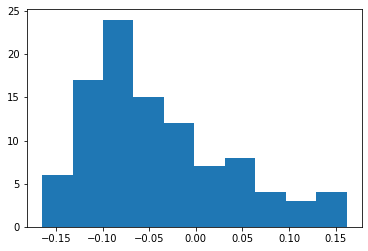

In [183]:
plt.hist(rank_corr_per_dim)

In [172]:
from scipy.stats import kendalltau

# calculate kendall's correlation
coef, p = kendalltau(
    x=adj_hat.flatten(),
    y=adjacency_true.flatten()
)

print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Kendall correlation coefficient: -0.032
Samples are correlated (reject H0) p=0.001


---

## Exploration of results

In [167]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]
adj_hat

array([[0.00141, 0.00181, 0.00855, ..., 0.00943, 0.00923, 0.01304],
       [0.00311, 0.00129, 0.01251, ..., 0.00915, 0.00726, 0.01185],
       [0.00343, 0.00186, 0.04852, ..., 0.0099 , 0.00796, 0.01432],
       ...,
       [0.02883, 0.01501, 0.01245, ..., 0.00958, 0.01153, 0.02437],
       [0.01216, 0.00995, 0.00887, ..., 0.03078, 0.01442, 0.02328],
       [0.00137, 0.00276, 0.00194, ..., 0.0191 , 0.01991, 0.01562]])

In [168]:
adj_hat.nonzero()

(array([  0,   0,   0, ..., 622, 622, 622]),
 array([  0,   1,   2, ..., 620, 621, 622]))

In [170]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]

thresh_list = np.linspace(0.01, 0.15, 20)

vals_vifb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0
    print(np.round(thresh, 3), len(adj_hat_thresh.nonzero()[0]))

    for k in [5, 10, 20]:
        vals_vifb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

0.01 68288
0.017 31004
0.025 17360
0.032 11503
0.039 8389
0.047 6450
0.054 5161
0.062 4092
0.069 3304
0.076 2612
0.084 2068
0.091 1641
0.098 1313
0.106 912
0.113 804
0.121 720
0.128 658
0.135 604
0.143 551
0.15 516


In [159]:
thresh_list = np.linspace(0.01, 0.15, 20)

vals_gb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0

    for k in [5, 10, 20]:
        vals_gb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

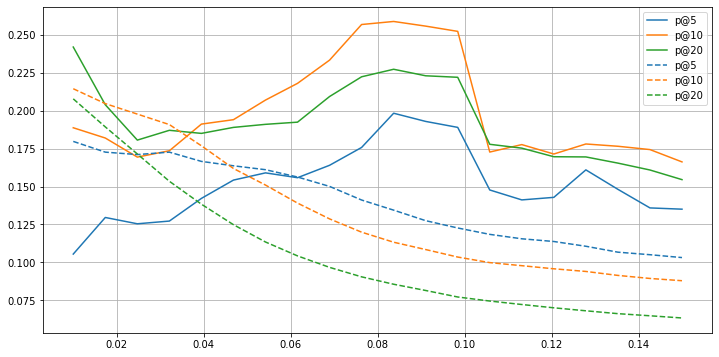

In [161]:
plt.figure(figsize=(12, 6))
plt.grid()

plt.plot(thresh_list, vals_vifb[5], label='p@5')
plt.plot(thresh_list, vals_vifb[10], label='p@10')
plt.plot(thresh_list, vals_vifb[20], label='p@20')

plt.plot(thresh_list, vals_gb[5],   label='p@5', c='C0', ls='--')
plt.plot(thresh_list, vals_gb[10], label='p@10', c='C1', ls='--')
plt.plot(thresh_list, vals_gb[20], label='p@20', c='C2', ls='--')

plt.legend();